In [1]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
import ee
ee.Initialize()

In [30]:
ex = np.genfromtxt("results_comparison/compiled_australia_passing.csv", delimiter=',', skip_header=1)

In [31]:
new_array = np.empty((0,18), float)
for row in ex:
    min_lon = row[0]
    min_lat = row[1]
    max_lon = row[2]
    max_lat = row[3]
    
    # Center Lon/Lat positions:
    center_lon = min_lon + (max_lon-min_lon)/2
    center_lat = min_lat + (max_lat-min_lat)/2
    
    new_row = np.append(row, [center_lon, center_lat], axis=None)
    new_array = np.append(new_array, np.array([new_row]), axis=0)

In [32]:
# Columns
lons = new_array[:,16]
lats = new_array[:,17]
b5_vals = new_array[:,13]
b6_vals = new_array[:,14]
# Interpolate all the center lon/lat positions with the data metrics.
interp_b5 = LinearNDInterpolator((lons, lats), b5_vals)
interp_b6 = LinearNDInterpolator((lons, lats), b6_vals)

In [33]:
new_array3 = np.empty((0,19), float)
for row in new_array:
    center_lon = row[16]
    center_lat = row[17]
    b5 = row[13]
    b6 = row[14]
    nd = ((b5 - b6)/(b5 + b6))
    score = 0
    
    change = 250*0.00001
    
    # Left and right neighbors will have the same center lat
    left = [center_lon - change, center_lat]
    right = [center_lon + change, center_lat]
    # Up and down neighbors will have the same center lon
    up = [center_lon, center_lat + change]
    down = [center_lon, center_lat - change]
    # Corner neighbors
    ul = [center_lon - change, center_lat + change]
    ur = [center_lon + change, center_lat + change]
    dl = [center_lon - change, center_lat - change]
    dr = [center_lon + change, center_lat - change]
    
    neighbors = [left, right, up, down, ul, ur, dl, dr]
    for x in neighbors:
        x_b5 = interp_b5.__call__(x[0], x[1])
        x_b6 = interp_b6.__call__(x[0], x[1])
        x_nd = ((x_b5 - x_b6)/(x_b5 + x_b6))
        if (abs(nd - x_nd) > 0.05):
            score = score+1
            
    new_row = np.append(row, score, axis=None)
    new_array3 = np.append(new_array3, np.array([new_row]), axis=0)

In [34]:
# Convert to a Feature Collection
# Create a list of Features for areas, with score as property

region_list = []
for row in new_array3:
    region = ee.Geometry.Polygon([[[float(row[0]), float(row[3])],
                                  [float(row[0]), float(row[1])],
                                  [float(row[2]), float(row[1])],
                                  [float(row[2]), float(row[3])]]])
    f = ee.Feature(region).set('b5/b6 score', float(row[18]))
    region_list.append(f)

# Wrap feature list in a Feature Collection
fc = ee.FeatureCollection(region_list)

# Export the Feature Collection to Google Earth Engine (GEE)
task = ee.batch.Export.table.toAsset(**{
  'collection': fc,
  'description':'compiled_results_d',
  'assetId': 'users/EmilyNason/Australia_Score_Bands', # must be unique name
});

task.start()

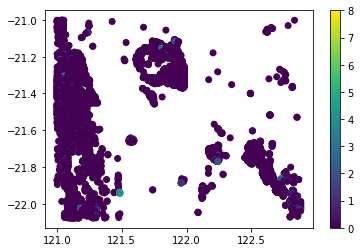

In [35]:
fig=plt.figure()
sc = plt.scatter(new_array3[:,16],new_array3[:,17],c=new_array3[:,18],vmin=0,vmax=8)
plt.colorbar(sc)
plt.show()